***
# Modele de prédiction
***

In [1]:
# ====== Importer les library ====== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


pd.set_option('display.max_columns', None)

In [2]:
# ====== Déterminer les path ====== #
import os
cwd = os.getcwd()

df_path = cwd + '\\dataframe\\'

In [3]:
# ====== Importer les df ====== #
df = pd.read_hdf(df_path + 'df_merge.h5')

df.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,comment_count,like_count,message_comments,mainTopic,message_posts,secondTopic,shares,title,time_difference,year,month,weekday,IDENTITY_ATTACK_cube,INSULT_cube,PROFANITY_cube,SEVERE_TOXICITY_cube,THREAT_cube,TOXICITY_cube,comment_count_cube,like_count_cube,shares_cube,messages_clean,emojis,emojis_text,positive,neutral,negative,emoji_count,title_classify,comment_lenght,label,score,AT,question_label,question_score,question_bool
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,"Faux, ce ne sera jamais le temps pour lui car ...",composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,3.0,2023,6,4,0.467562,0.866814,0.872661,0.705121,0.310492,0.838017,0.0,0.0,0.0,Faux jamais temps réélu parti crève faim Jamai...,[],[],0.077610,0.130838,0.791552,0,Environnement,52,LABEL_0,0.988207,0,LABEL_0,0.988207,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,1,Mon dieu!! On nous prend sérieusement pour des...,composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,18.0,2023,6,4,0.176257,0.551253,0.634546,0.191119,0.178081,0.560745,1.0,1.0,0.0,dieu prend sérieusement idiots,[😅],[grinning_face_with_sweat],0.697028,0.047872,0.255100,1,Environnement,10,LABEL_0,0.987274,0,LABEL_0,0.987274,0


In [4]:
def normalizeCols(df, cols):
    for col in cols:
        df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
    return df

In [34]:
# ====== Baseline ====== #
df_model = df.copy()
df_model['comments_binary'] = np.where(df_model['comment_count']==0, 0, 1)

col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'comments_binary']

df_model = df_model[col_to_keep]

# independent values 
col_independent = []
for col in df_model.columns.tolist():
    if (col != 'comments_binary') & (col != 'comment_count'):
        col_independent.append(col)

if 'comments_binary' in df_model.columns.tolist():
    col_dependent = 'comments_binary'
else :
    col_dependent = 'comment_count'


# normalizeCols(df_model, ['like_count', 'shares'])

# undersampling = False
undersampling = True

df_model.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,comments_binary
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,0,1


In [70]:
# ======= Tout les attributs ======= #
df_model = df.copy()
df_model['comments_binary'] = np.where(df_model['comment_count']==0, 0, 1)


df_model = pd.get_dummies(df_model, columns = ['year', 'weekday', 'title_classify'])

col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'time_difference', 'positive', 'negative', 'comment_lenght', 'AT', 'question_bool', 'emoji_count','comments_binary']
columns = ['year', 'weekday', 'title_classify']

# Include hotencoded attributs
for col in df_model.columns.to_list():
    for column in columns:
        if column in col:
            col_to_keep.append(col)


df_model = df_model[col_to_keep]

if  'time_difference' in col_to_keep :
    df_model['time_difference'] = np.where(df_model['time_difference']<0, 0, df_model['time_difference'])

# independent values 
col_independent = []
for col in df_model.columns.tolist():
    if (col != 'comments_binary') & (col != 'comment_count'):
        col_independent.append(col)

if 'comments_binary' in df_model.columns.tolist():
    col_dependent = 'comments_binary'
else :
    col_dependent = 'comment_count'

# Drop negatif time_difference
df_model = df_model.loc[df_model['time_difference']>0].copy()


# Normalize columns
cols = ['like_count', 'shares', 'time_difference', 'comment_lenght', 'emoji_count']
df_model = normalizeCols(df_model, cols)
df_model.head()

undersampling = True
df_model.head()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,time_difference,positive,negative,comment_lenght,AT,question_bool,emoji_count,comments_binary,year_2020,year_2021,year_2022,year_2023,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,title_classify_COVID,title_classify_Environnement,title_classify_Justice,title_classify_Politique,title_classify_Santé,title_classify_Sport,title_classify_Technologie,title_classify_Économie,title_classify_Éducation
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0.000000,0.0,0.000001,0.077610,0.791552,0.039658,0,0,0.000000,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,0.001196,0.0,0.000012,0.697028,0.255100,0.006998,0,0,0.006329,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0.029144,0.269578,0.016753,0.006104,0.005864,0.246033,0.000000,0.0,0.000060,0.243069,0.667599,0.046656,0,0,0.000000,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,0.036105,0.402434,0.479813,0.023411,0.008220,0.372227,0.000000,0.0,0.000066,0.685404,0.189553,0.008554,0,0,0.000000,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0.280349,0.520819,0.163573,0.169603,0.008790,0.439655,0.000000,0.0,0.000066,0.158446,0.599248,0.012442,0,0,0.000000,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [71]:
df_model.describe()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,time_difference,positive,negative,comment_lenght,AT,question_bool,emoji_count,comments_binary,year_2020,year_2021,year_2022,year_2023,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,title_classify_COVID,title_classify_Environnement,title_classify_Justice,title_classify_Politique,title_classify_Santé,title_classify_Sport,title_classify_Technologie,title_classify_Économie,title_classify_Éducation
count,9.268930e+05,926893.000000,926893.000000,9.268930e+05,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000,926893.000000
mean,1.145923e-02,0.109345,0.052690,1.366041e-02,0.010193,0.102814,0.001588,0.011108,0.001293,0.370189,0.442540,0.016530,0.000900,0.109358,0.001416,0.123938,0.375859,0.341798,0.166345,0.115998,0.136060,0.154557,0.155660,0.150881,0.150744,0.129400,0.122697,0.176571,0.106229,0.054465,0.142701,0.072169,0.066346,0.072634,0.065682,0.243203
std,4.016004e-02,0.163214,0.120186,5.624640e-02,0.035218,0.140308,0.007172,0.071970,0.014629,0.247017,0.237336,0.027594,0.029983,0.312088,0.003880,0.329511,0.484344,0.474312,0.372390,0.320223,0.342852,0.361482,0.362533,0.357934,0.357800,0.335642,0.328089,0.381305,0.308131,0.226933,0.349768,0.258768,0.248887,0.259535,0.247725,0.429017
min,3.613072e-08,0.002280,0.000000,3.725290e-08,0.000000,0.000005,0.000000,0.000000,0.000000,0.003074,0.000853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.249071e-04,0.009546,0.008888,4.243851e-04,0.005321,0.008419,0.000000,0.000271,0.000091,0.163339,0.260180,0.003888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.590908e-03,0.027731,0.011287,1.220703e-03,0.005497,0.034513,0.000000,0.001044,0.000346,0.322117,0.419297,0.009331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.512681e-03,0.137888,0.022218,4.711151e-03,0.006233,0.151587,0.001196,0.004213,0.001067,0.534297,0.624711,0.019440,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.491525e-01,0.973575,0.991138,9.502075e-01,0.968038,0.981763,1.000000,1.000000,1.000000,0.996014,0.988329,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [132]:
# df_model.to_hdf(cwd + '\\dataframe\\' + 'df_model.h5', key='s')

***
### Fonction
***

In [69]:
def modelScore(y_test, y_prediction):
    tn, fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    
    evaluation = round(tp / (tp+fp+fn), 2)
    print(f"Évaluation : {evaluation}")

    accuracy = accuracy_score(y_test, y_prediction)
    print(f"Accuracy: {accuracy:.2f}")

    precision = precision_score(y_test, y_prediction)
    print(f"Precision: {precision:.2f}")

    recall = recall_score(y_test, y_prediction)
    print(f"Recall: {recall:.2f}")

    f1 = f1_score(y_test, y_prediction)
    print(f"f1_score: {f1:.2f}")

def costumMetric(y_test, y_prediction):
    fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    evaluation = round(tp / (tp+fp+fn), 2)
    return evaluation


def custom_evaluation_score(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    precision = TP / (TP + FP + FN)
    return precision


def evalutationMetrics(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f'TP : {tp}')
    print(f'TN : {tn}')
    print(f'FP : {fp}')
    print(f'FN : {fn}')
    print(f'N : {tn  +fp + fn + tp}')
    


def featureImportance(classifier, X_test, y_test):
    feature_names = X_test.columns
    imps = permutation_importance(classifier, X_test, y_test)
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': imps.importances_mean})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print("\nFeature Importance:\n", feature_importance_df)
    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance


def confusionMatricePlot(y_test, y_prediction, save_Name=None):
    cm = confusion_matrix(y_test, y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    if save_Name != None:
        plt.savefig(f'{save_Name}.png')
    plt.show()


def durationTime(start_time, end_time):
    duration = (end_time - start_time)
    minutes = duration // 60
    seconds = duration % 60
    print(f'Running time (min): {int(minutes)}.{int(seconds)}')


def randomUnderSampling(X, y):
    X = df_model[col_independent]
    y = df_model[col_dependent]
    print('Original dataset shape %s' % Counter(y))

    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)

    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

***
### Logit
***

In [72]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Probit.html#statsmodels.discrete.discrete_model.Probit
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 
classifier = LogisticRegression(random_state=0, class_weight='balanced', max_iter=500).fit(X_train, y_train)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()


Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})
Cross-validation scores: [0.41142365 0.40825584 0.41223716 0.40671524 0.41396825]
Mean CV score: 0.4105200293130908


In [112]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71     28789
           1       0.76      0.42      0.54     28701

    accuracy                           0.65     57490
   macro avg       0.68      0.64      0.63     57490
weighted avg       0.68      0.65      0.63     57490



In [73]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.41
Accuracy: 0.63
Precision: 0.66
Recall: 0.52
f1_score: 0.58
Running time (min): 0.13


In [49]:
evalutationMetrics(y_test, y_prediction)

TP : 14911
TN : 21200
FP : 7646
FN : 13682
N : 57439


***
### Random forest
***

In [20]:
# df_model = df_model.head(100)

In [134]:
# Code pour optimiser les hyperparamètres
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import numpy as np

def costumMetric(y_test, y_prediction):
    fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    denominator = (tp+fp+fn)
    if denominator == 0:
        return 0
    evaluation = round(tp / (tp+fp+fn), 2)
    return evaluation

custom_scorer = make_scorer(costumMetric, greater_is_better=True)

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

param_dist = {
    'n_estimators': np.random.randint(100, 500, 10),
    'max_depth': [None] + list(np.linspace(3, 20, 5).astype(int)),
    'min_samples_split': list(range(2, 21, 2)),
    'min_samples_leaf': list(range(1, 21, 2)),
    'max_features': ['sqrt', 'log2', None]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)

# y_pred = random_search.predict(X_test)
# print(f"Test set evaluation: {costumMetric(y_test, y_pred)}")

Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})


C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best hyperparameters: {'n_estimators': 390, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'max_depth': 20}


In [19]:
# df_model = df_model.head(10000).copy()

In [74]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]

if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

classifier = RandomForestClassifier(n_estimators=390, min_samples_split=20, min_samples_leaf=15, max_features='sqrt', max_depth=20)
# classifier = RandomForestClassifier()

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()
# 34

Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})
Cross-validation scores: [0.53532907 0.53662457 0.53828477 0.53563764 0.54240096]
Mean CV score: 0.5376554010218856


In [218]:
col_list = ['message_comments', 'like_count', 'shares','time_difference', 'comment_lenght' ,'emoji_count']

df_results = X_test
df_results['y_true'] = y_test
df_results['y_pred'] = y_prediction
df_results = pd.merge(df_results, df[col_list], how='left', left_index=True, right_index=True, suffixes=('_normalize', '_orig'))
df_results.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count_normalize,shares_normalize,time_difference_normalize,positive,negative,comment_lenght_normalize,AT,question_bool,emoji_count_normalize,year_2020,year_2021,year_2022,year_2023,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,title_classify_COVID,title_classify_Environnement,title_classify_Justice,title_classify_Politique,title_classify_Santé,title_classify_Sport,title_classify_Technologie,title_classify_Économie,title_classify_Éducation,y_pred,y_true,message_comments,like_count_orig,shares_orig,time_difference_orig,comment_lenght_orig,emoji_count_orig
332202,0.001170,0.026187,0.010895,0.000992,0.005341,0.030978,0.017943,0.000541,0.000006,0.423440,0.399401,0.057543,0,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,"Booonnnn, v'la autre chose encore pour faire p...",15,14,10.0,75,0
158498,0.003052,0.053206,0.009289,0.001268,0.005341,0.053542,0.002392,0.000271,0.000739,0.420573,0.389443,0.052100,0,0,0.006329,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,L'école sera encore moins adaptée pour les élè...,2,7,1050.0,68,1


In [233]:
# print(len(df_results))
for row in range(200):
    y_true = df_results['y_true'].iloc[row]
    y_pred = df_results['y_pred'].iloc[row]
    if (y_true == 0 ) & (y_pred == 1):
        print(f'Row : {row}')
        print(f'y_true = {y_true}, y_pred = {y_pred}')
        print(df_results['message_comments'].iloc[row])


Row : 4
y_true = 0, y_pred = 1
Sylvie Daoust L'experte en matière policière assise dans son salon. On devrait te mettre devant un homme qui essaye de te poignarder et on va te regarder faire. J'ai l'impression que tu vas mieux comprendre la situation après. Tu présumes que la personne n'a effectué aucune manoeuvre avec son couteau. Tu présumes que les policiers n'ont pas utilisé d'autres moyens avant leur arme à feu. Tu présumes que les policiers étaient racistes. Et tu présumes que les policiers étaient peureux.Tu vois? C'est que du vent. C'est un scénario que tu as monté dans ta tête sans regarder les faits. Laisse faire les professionnels et continue d'épousseter tes verres à vin.
Row : 19
y_true = 0, y_pred = 1
Juliette Monette 
Row : 25
y_true = 0, y_pred = 1
Mon cousin est parti vivre là depuis 25 ans
Row : 28
y_true = 0, y_pred = 1
Bravo bravo bravo!!!!!!!!!!
Surtout les medecins, tenez votre bout!
Row : 33
y_true = 0, y_pred = 1
Sylvain Parenteau puis juste des maths très simpl

In [230]:
test = df_results.iloc[16]
test

IDENTITY_ATTACK                          0.004736
INSULT                                   0.009983
PROFANITY                                0.018392
SEVERE_TOXICITY                          0.001812
THREAT                                   0.007599
TOXICITY                                  0.01998
like_count_normalize                          0.0
shares_normalize                         0.000387
time_difference_normalize                  0.0019
positive                                 0.931363
negative                                 0.014976
comment_lenght_normalize                 0.002333
AT                                              0
question_bool                                   0
emoji_count_normalize                         0.0
year_2020                                       0
year_2021                                       1
year_2022                                       0
year_2023                                       0
weekday_0                                       0


In [241]:
col_list = ['IDENTITY_ATTACK', 
            'INSULT', 
            'PROFANITY', 
            'SEVERE_TOXICITY', 
            'THREAT', 
            'TOXICITY', 
            'like_count_orig',
            'shares_orig', 
            'time_difference_orig', 
            'comment_lenght_orig', 
            'emoji_count_orig', 
            'positive', 
            'negative']
df_exemple = df_results[col_list].describe().T
df_exemple = df_exemple[['mean', '50%']]
df_exemple['tp'] = df_results[col_list].iloc[66]
df_exemple['tn'] = df_results[col_list].iloc[16]
df_exemple['fp'] = df_results[col_list].iloc[28]
df_exemple['fn'] = df_results[col_list].iloc[103]
df_exemple

,mean,50%,tp,tn,fp,fn
IDENTITY_ATTACK,0.011884,0.001693,0.015255,0.004736,0.009471,0.003274
INSULT,0.102709,0.027841,0.116167,0.009983,0.157695,0.338892
PROFANITY,0.046726,0.011321,0.013576,0.018392,0.015523,0.072559
SEVERE_TOXICITY,0.011660,0.001249,0.007896,0.001812,0.005035,0.006447
THREAT,0.010640,0.005521,0.006777,0.007599,0.007172,0.005552
TOXICITY,0.097214,0.034513,0.132146,0.019980,0.142560,0.254629
like_count_orig,2.799004,0.000000,1.000000,0.000000,2.000000,0.000000
shares_orig,270.486516,28.000000,18.000000,10.000000,195.000000,2.000000
time_difference_orig,1355.712286,335.000000,608.000000,2697.000000,683.000000,77.000000
comment_lenght_orig,22.183360,13.000000,35.000000,4.000000,9.000000,15.000000


In [240]:
df_results[col_list].describe()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count_orig,shares_orig,time_difference_orig,comment_lenght_orig,emoji_count_orig,positive,negative
count,5.743900e+04,57439.000000,57439.000000,5.743900e+04,57439.000000,57439.000000,57439.000000,57439.000000,57439.000000,57439.000000,57439.000000,57439.000000,57439.000000
mean,1.188380e-02,0.102709,0.046726,1.165996e-02,0.010640,0.097214,2.799004,270.486516,1355.712286,22.183360,0.232142,0.364395,0.449658
std,4.113135e-02,0.152581,0.107288,4.968474e-02,0.037314,0.130599,11.524712,1703.116763,14220.085300,34.459579,0.513995,0.242775,0.238370
min,3.613072e-08,0.004711,0.000000,1.117587e-07,0.000000,0.000007,0.000000,0.000000,1.000000,1.000000,0.000000,0.004169,0.001072
25%,5.595926e-04,0.009508,0.008982,4.529953e-04,0.005332,0.008419,0.000000,7.000000,84.000000,6.000000,0.000000,0.158909,0.259873
50%,1.692652e-03,0.027841,0.011321,1.249313e-03,0.005521,0.034513,0.000000,28.000000,335.000000,13.000000,0.000000,0.318109,0.425078
75%,5.808664e-03,0.117977,0.021057,4.501343e-03,0.006272,0.139089,2.000000,113.000000,1309.500000,26.000000,0.000000,0.533819,0.635906
max,9.356644e-01,0.898717,0.923894,8.680654e-01,0.850388,0.924899,836.000000,25872.000000,932637.000000,1118.000000,16.000000,0.995417,0.987538


In [236]:
for col in [66, 16, 28, 103]:
    print(df_results['message_comments'].iloc[col])
    print('*'*25)

La tendance pro vaxx 😉
Vous devriez vous faire enlever vôtre permis de conduire, vous êtes maintenant à risque élevé pour un avc ou une crise cardiaque 🤷‍♂️
On sauvent des vies qu'ils disaient 😂😂😂
*************************
moi jai bien aime
*************************
Bravo bravo bravo!!!!!!!!!!
Surtout les medecins, tenez votre bout!
*************************
Une grosse comédie ... comme Jacques Gourde au Fédéral ... du GROS N'IMPORTE QUOI  😡
*************************


In [ ]:
# ====== Subject ====== #

# Df avec les sujet attribué aux articles
df  = pd.read_hdf(cwd + '\\dataframe\\' + 'df_topics.h5')

# Ajouter au df_merge
df_merge = pd.merge(left=df_merge, right=df, how='left', on='title')

# S'assurer qu'il n'y ait pas de valeurs manquantes
df_merge['title_classify'].unique()

array([nan, 'Santé', 'Politique', 'Éducation', 'Environnement', 'Sport',
       'Économie', 'COVID', 'Technologie', 'Justice'], dtype=object)

In [137]:
# ====== Save model ====== #
# from joblib import dump, load
# dump(classifier, 'randomForest.joblib')

['randomForest.joblib']

In [75]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.54
Accuracy: 0.71
Precision: 0.72
Recall: 0.68
f1_score: 0.70
Running time (min): 11.51


In [124]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    203084
           1       0.61      0.14      0.23     28727

    accuracy                           0.88    231811
   macro avg       0.75      0.56      0.58    231811
weighted avg       0.86      0.88      0.85    231811



In [60]:
evalutationMetrics(y_test, y_prediction)

TP : 19487
TN : 21275
FP : 7571
FN : 9106
N : 57439


In [15]:
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(y_test, y_prediction, target_names=target_names))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72     28846
           1       0.72      0.68      0.70     28593

    accuracy                           0.71     57439
   macro avg       0.71      0.71      0.71     57439
weighted avg       0.71      0.71      0.71     57439



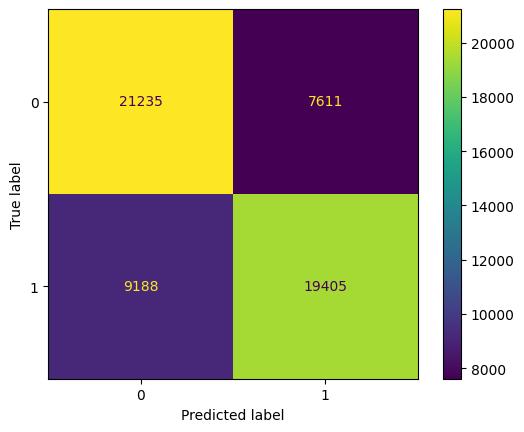

In [12]:
confusionMatricePlot(y_test, y_prediction, 'DecisionTreeConfusionMatrix')

In [200]:
# Feature importance based on mean decrease in impurity

start_time = time.time()
feature_names = X.columns.to_list()
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.713 seconds


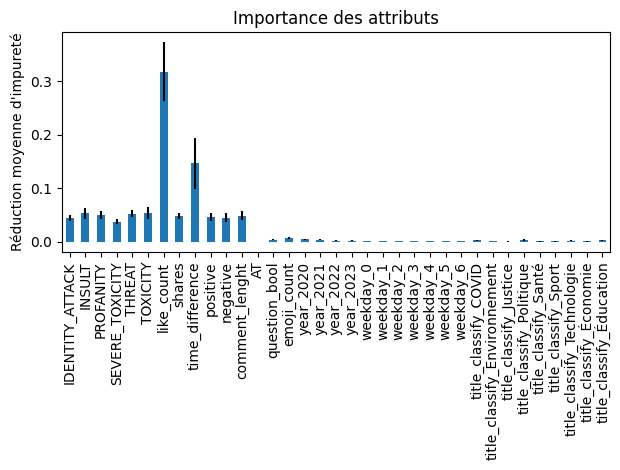

In [237]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importance des attributs")
ax.set_ylabel("Réduction moyenne d'impureté")
plt.savefig('FeatureImportance.png', dpi=300, bbox_inches='tight')
fig.tight_layout()

***
### Naive Bayes
***

In [78]:
from sklearn.naive_bayes import GaussianNB

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, test_size=0.25, shuffle=True, )
classifier = GaussianNB()

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

classifier.fit(X, y)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()

Original dataset shape Counter({0: 812261, 1: 114980})
Resampled dataset shape Counter({0: 114980, 1: 114980})
Cross-validation scores: [0.22389811 0.24841543 0.22465999 0.24311876 0.22594048]
Mean CV score: 0.2332065535951983


In [79]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.24
Accuracy: 0.60
Precision: 0.85
Recall: 0.25
f1_score: 0.38
Running time (min): 0.0


In [53]:
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, test_size=0.25, shuffle=True, )
classifier = MultinomialNB(alpha=1)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

classifier.fit(X, y)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()

Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})
Cross-validation scores: [0.39278666 0.39049867 0.3856419  0.38823529 0.38657551]
Mean CV score: 0.3887476054945727


In [54]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.39
Accuracy: 0.54
Precision: 0.54
Recall: 0.58
f1_score: 0.56
Running time (min): 0.0


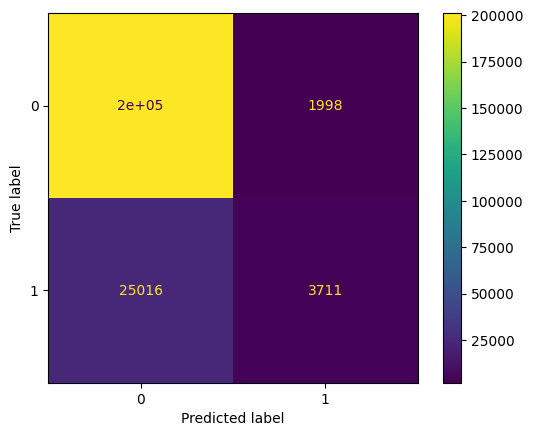

In [73]:
confusionMatricePlot(y_test, y_prediction)

In [114]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.62      0.72      0.66     28739
           1       0.66      0.56      0.61     28751

    accuracy                           0.64     57490
   macro avg       0.64      0.64      0.64     57490
weighted avg       0.64      0.64      0.64     57490



In [55]:
evalutationMetrics(y_test, y_prediction)

TP : 16710
TN : 14546
FP : 14216
FN : 11967
N : 57439


***
### Gradient-Boosting
***

In [93]:
# Code pour optimiser les hyperparamètres
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import numpy as np

def costumMetric(y_test, y_prediction):
    fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    denominator = (tp+fp+fn)
    if denominator == 0:
        return 0
    evaluation = round(tp / (tp+fp+fn), 2)
    return evaluation

custom_scorer = make_scorer(costumMetric, greater_is_better=True)

X = df_model[col_independent]
y = df_model[col_dependent]
if undersampling == True: 
    X, y = randomUnderSampling(X, y)

param_dist = {
    'n_estimators': np.random.randint(100, 500, 10),
    'max_depth': [None] + list(np.linspace(3, 20, 5).astype(int)),
    'min_samples_split': list(range(2, 21, 2)),
    'learning_rate': np.linspace(0.5, 1.0, 20).tolist()
}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

random_search = RandomizedSearchCV(
    GradientBoostingClassifier(),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best hyperparameters:", random_search.best_params_)

# y_pred = random_search.predict(X_test)
# print(f"Test set evaluation: {costumMetric(y_test, y_pred)}")

Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})


C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best hyperparameters: {'n_estimators': 272, 'min_samples_split': 16, 'max_depth': None, 'learning_rate': 0.8157894736842105}


In [56]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]

if undersampling == True: 
    X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)

classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0, min_samples_split=2).fit(X_train, y_train)
# classifier = GradientBoostingClassifier(n_estimators=272, learning_rate=0.8157894736842105, random_state=0, min_samples_split=16).fit(X_train, y_train)

classifier.score(X_train, y_train)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring=custom_scorer)

y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
end_time = time.time()

Original dataset shape Counter({0: 812016, 1: 114877})
Resampled dataset shape Counter({0: 114877, 1: 114877})
Cross-validation scores: [0.50948184 0.50637205 0.51133641 0.50654661 0.50635008]
Mean CV score: 0.5080173988038358


In [57]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.51
Accuracy: 0.69
Precision: 0.72
Recall: 0.65
f1_score: 0.68
Running time (min): 1.32


In [45]:
evalutationMetrics(y_test, y_prediction)

TP : 17200
TN : 21467
FP : 7105
FN : 11718
N : 57490


In [ ]:
confusionMatricePlot(y_test, y_prediction)

In [116]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.65      0.75      0.70     28572
           1       0.71      0.59      0.65     28918

    accuracy                           0.67     57490
   macro avg       0.68      0.67      0.67     57490
weighted avg       0.68      0.67      0.67     57490

